# <center><b> Práctica 3 de Laboratorio 5 </b><br><u> Conteo de Fotones </u></center>

Grupo 1: Trinidad Borrel, Bruno Sivilotti, Agustín Brusco

In [1]:
import pyvisa as visa
# import nidaqmx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
# Formato para matplotlib
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 120
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'
rcParams['axes.xmargin'] = 0
rcParams['axes.grid'] = True

from instrumental import TDS1002B
try:
    rm.close()
except NameError:
    pass
rm = visa.ResourceManager()

instruments = rm.list_resources()
print(instruments)

for inst in instruments:
    if ('C108012::0::INSTR' in inst
        or 'C108013::0::INSTR' in inst
        or 'C065093::0::INSTR' in inst):  # Ojo si nos cambian el osciloscopio
        print('Osciloscopio TDS1002B detectado:',
            f'\nID: {inst}')
        osci = TDS1002B(inst)


('USB0::1689::867::C108012::0::INSTR',)
Osciloscopio TDS1002B detectado: 
ID: USB0::1689::867::C108012::0::INSTR
TEKTRONIX,TDS 1002B,C108012,CF:91.1CT FV:v22.13



In [2]:
def save_osci_data(t, *channels, filename=None):
    if filename is None:
        raise ValueError('Especificar `filename`.')
    osci_data = np.array([t, *channels],)
    np.save(filename, osci_data, )
    return None


config_code_dict = {
    "a": {"fotomultiplicador": False, "laser power": False, "laser light": False},
    "b": {"fotomultiplicador": True, "laser power": False, "laser light": False},
    "c": {"fotomultiplicador": True, "laser power": True, "laser light": False},
    "d": {"fotomultiplicador": True, "laser power": True, "laser light": True},
}

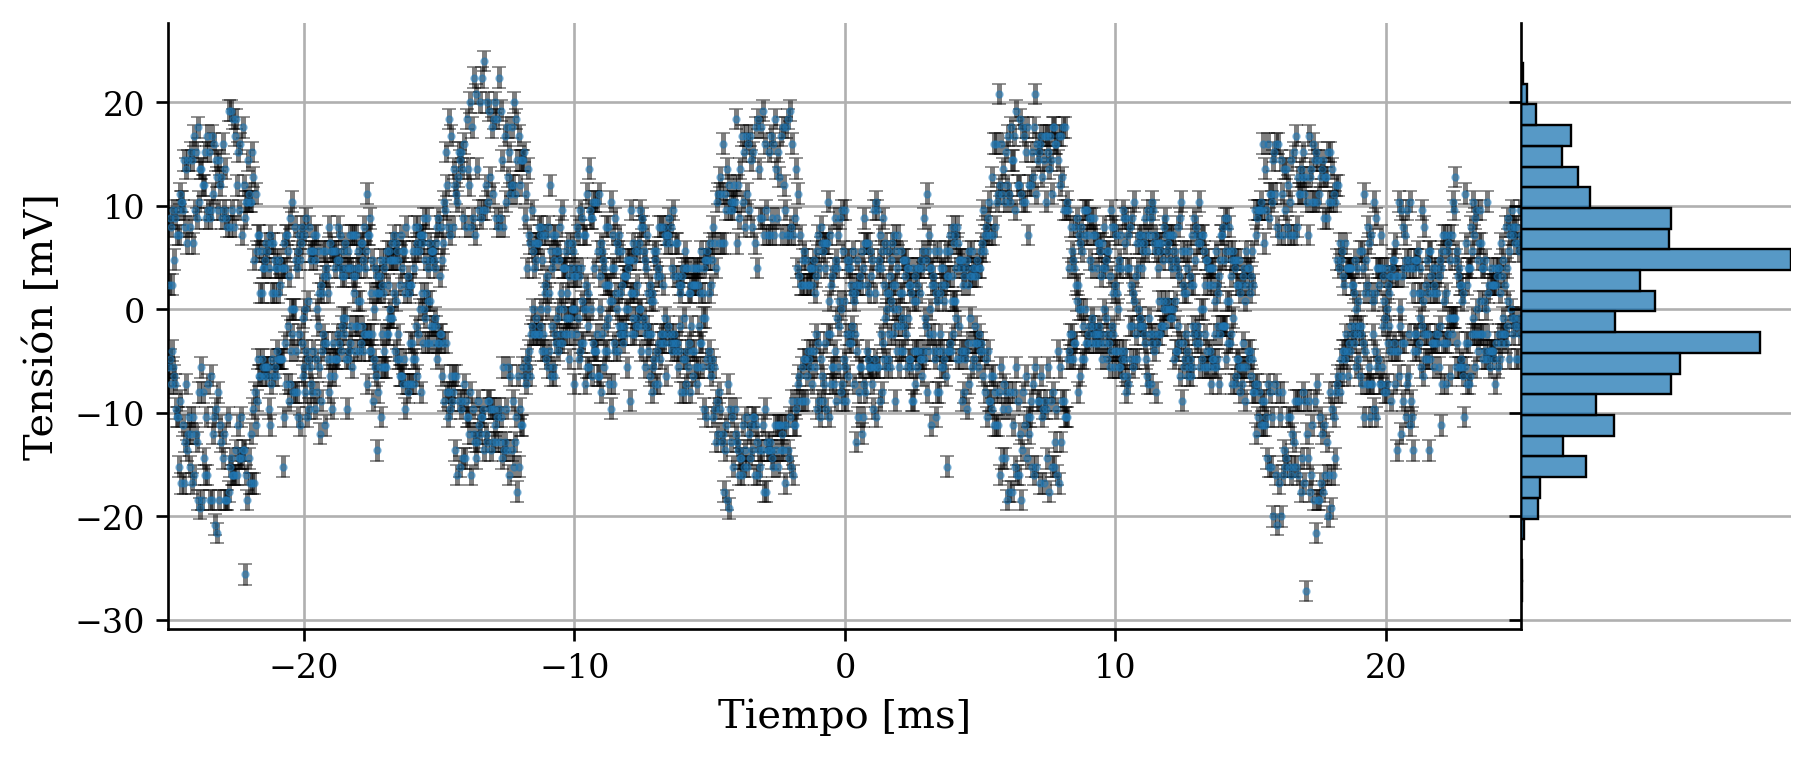

In [4]:
# Leer del osciloscopio:
tiempo, channel1 = osci.read_data(1)  # s, V

# Leer una tanda guardada:
# modo, angulo, tension, config = "sample", 230, 990, "d"
# tiempo, channel1 = np.load(f"osci_sample/{modo}_a{angulo}_t{tension}_{config}.npy")  # s, V
# tiempo = tiempo[:2500]
# channel1 = channel1[:2500]

res = 2e-3  # V
vals_unicos = np.unique(channel1)
bins = 1e3*np.arange(vals_unicos.min() - res/2, vals_unicos.max()+res/2, res)  # mV
g = sns.JointGrid(x=tiempo*1e3, y=channel1*1e3, height=4, ratio=5, space=0)
# g.plot_joint(plt.errorbar, xerr=np.diff(tiempo).mean(),
#              fmt='.', ms=2, mec="k", mew=0.5, alpha=0.5, ecolor='k', capsize=2, zorder=10)
g.plot_joint(plt.errorbar, yerr=1e3*res/2,
             fmt=".", ms=4, mec="C0", mew=0.5,
             ecolor="k", capsize=2, alpha=0.5, zorder=10)
g.ax_marg_x.set_visible(False)
g.plot_marginals(sns.histplot, bins=bins, zorder=10)
g.ax_joint.set_xlabel("Tiempo [ms]")
g.ax_joint.set_ylabel("Tensión [mV]")
g.ax_joint.set_xlim(min(tiempo*1e3), max(tiempo*1e3))
g.figure.set_size_inches((8, 3.5))
plt.show()

In [5]:
config = "c"  # Estado del instrumental al medir
tension = 1050  # Tensión en la fuente del fotomultiplicador
angulo = 230  # Ángulo relativo entre polarizadores a la salida del láser
modo = "fpeaks"  # Modo del osciloscopio: "fpeaks" para find peaks y "sample" para sampleo
tiempo = ["placeholder"]*10
channel1 = ["placeholder"]*10
for i in range(10):
    tiempo[i], channel1[i] = osci.read_data(1)  # s, V
    time.sleep(5e-3)
tiempo = np.concatenate(tiempo)
channel1 = np.concatenate(channel1)
np.save(f"pancita_osci/{modo}_a{angulo}_t{tension}_{config}.npy", np.array([tiempo, channel1]))

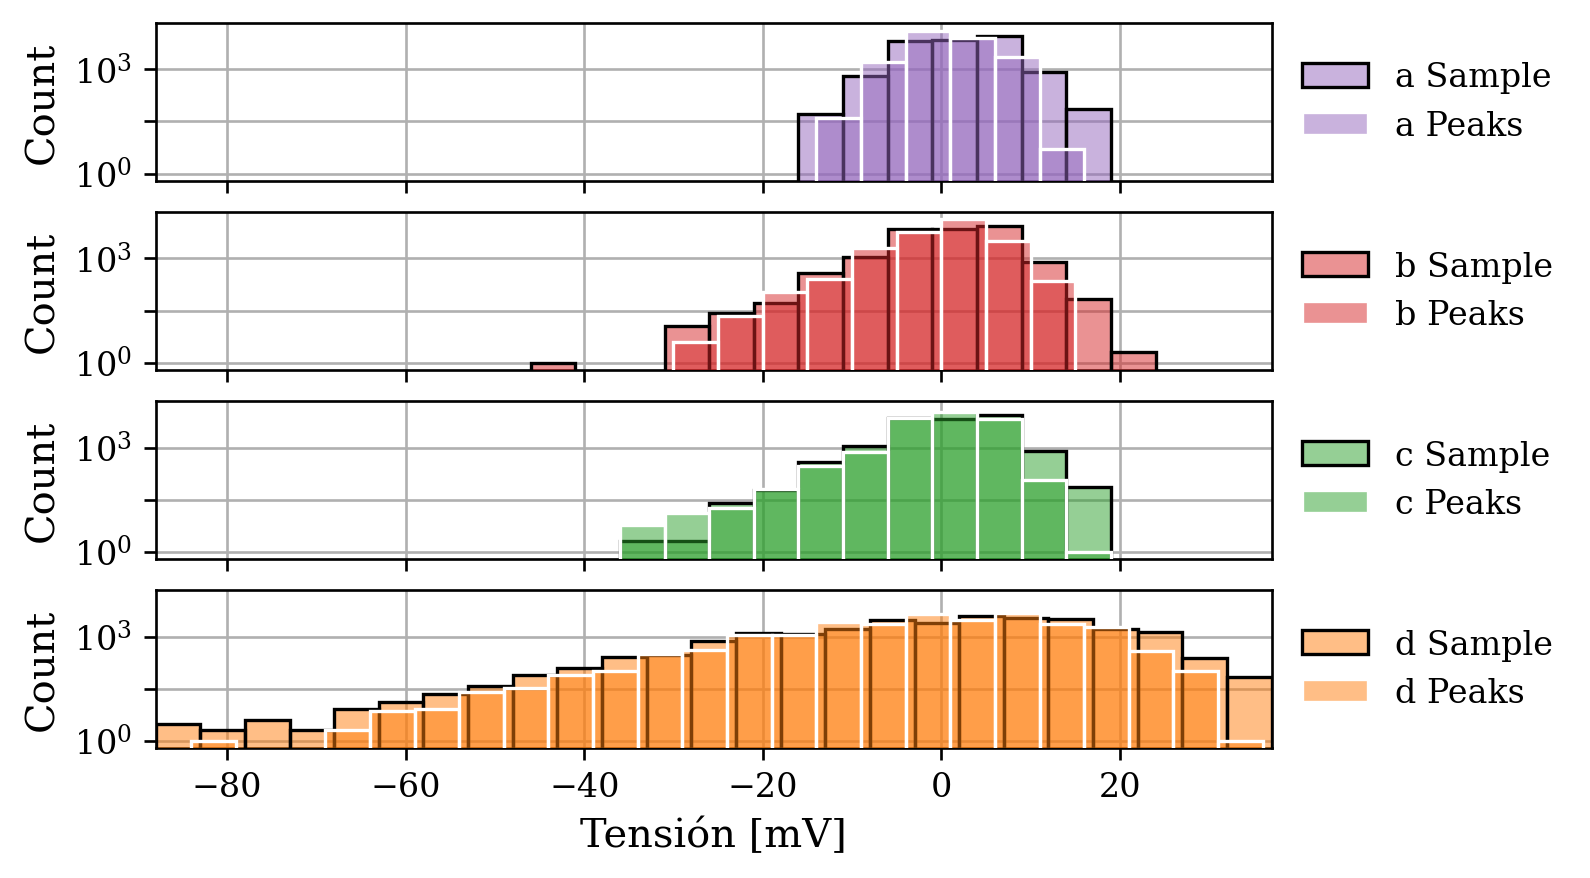

In [95]:
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True)
color_id = 4
angulo = 230
for config, tension, ax in zip(["a", "b", "c", "d"],
                                [0, 990, 990, 990],
                                axs):
    modo = "sample"
    tiempo, channel1 = np.load(f"osci_sample/{modo}_a{angulo}_t{tension}_{config}.npy")  # s, V
    sns.histplot(x=channel1*1e3, color=f"C{color_id}", binwidth=5, zorder=10, edgecolor="k",
                 #element="step", fill=False,
                 alpha=0.5,
                 label=config + " Sample", ax=ax)
    modo = "fpeaks"
    tiempo, channel1 = np.load(f"osci_peaks/{modo}_a{angulo}_t{tension}_{config}.npy")  # s, V
    sns.histplot(x=channel1*1e3, color=f"C{color_id}", binwidth=5, zorder=10, edgecolor="w",
                 #element="step", fill=False,
                 alpha=0.5,
                 label=config + " Peaks", ax=ax)
    color_id -= 1
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)
ax.set_yscale("log")
ax.set_yticks([1e0, 10**1.5, 1e3])
ax.set_xlabel("Tensión [mV]")
plt.show()

## Barrido Tensión

Nota: Los datos con ángulo de 240° no sirven porque la alta intensidad del haz nos desplazó el centro de las distribuciones

In [20]:
config = "c"  # Estado del instrumental al medir
tension = 1050  # Tensión en la fuente del fotomultiplicador
angulo = 230  # Ángulo relativo entre polarizadores a la salida del láser
modo = "fpeaks25ms"  # Modo del osciloscopio: "fpeaks" para find peaks y "sample" para sampleo

tiempo = ["placeholder"]*10
channel1 = ["placeholder"]*10
for i in range(10):
    tiempo[i], channel1[i] = osci.read_data(1)  # s, V
tiempo = np.concatenate(tiempo)
channel1 = np.concatenate(channel1)
np.save(f"pancita_osci/{modo}_a{angulo}_t{tension}_{config}.npy", np.array([tiempo, channel1]))

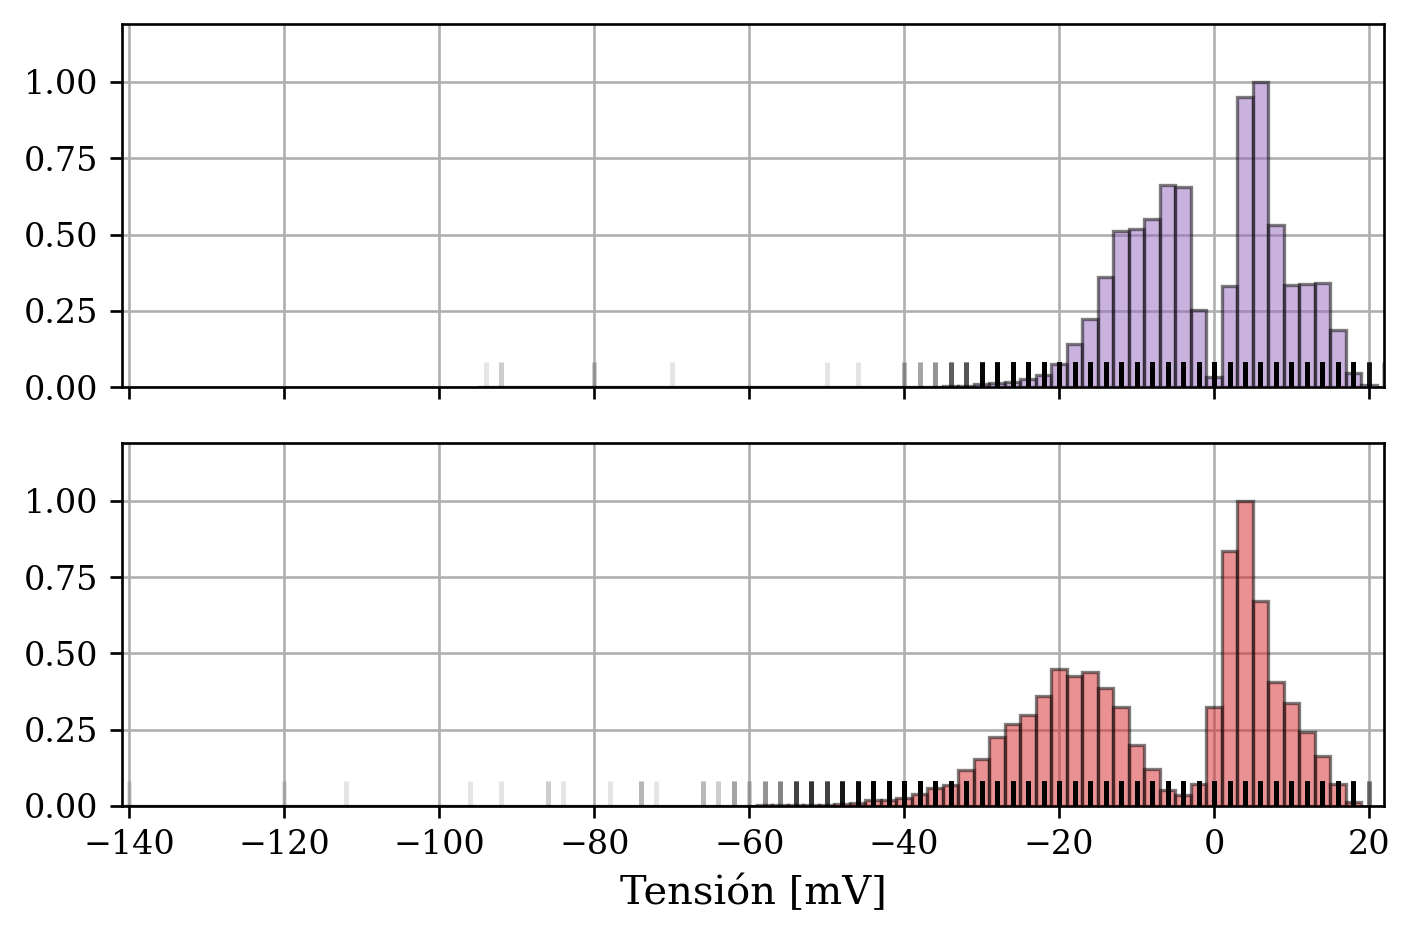

In [87]:
modo = "fpeaks10ms"
angulo = 230
tension = 1050
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, tight_layout=True)
fig.subplots_adjust(hspace=0)
color_id = 4
height_dict = dict()
tension_dict = dict()
for config, ax in zip(["c", "d"], axs):
    tiempo, channel1 = np.load(f"pancita_osci/{modo}_a{angulo}_t{tension}_{config}.npy")  # s, V
    res = 2e-3  # Escala en 50 mV
    # res = 4e-3  # Escala en 100 mV
    vals_unicos = np.unique(channel1,)
    bin_edges = np.arange(vals_unicos.min() - res/2, vals_unicos.max()+res/2, res)  # V
    count, bin_edges = np.histogram(channel1, bin_edges, )
    bin_center = np.arange(vals_unicos.min(), vals_unicos.max(), res)  # V
    bar_height = count/count.max()
    try:
        ax.bar(x=bin_center*1e3, height=bar_height, width=res*1e3,
                    color=f"C{color_id}", zorder=10, edgecolor="k",
                    alpha=0.5, label=config + " Sample")
    except ValueError:
        bin_center = np.arange(vals_unicos.min(), vals_unicos.max()+res/2, res)  # V
        bar_height = count/count.max()
        ax.bar(x=bin_center[:-1]*1e3, height=bar_height, width=res*1e3,
                    color=f"C{color_id}", zorder=10, edgecolor="k",
                    alpha=0.5, label=config + " Sample")
    sns.rugplot(x=channel1*1e3, c="k", height=0.07, alpha=0.1, lw=1.5, ax=ax, zorder=11)
    color_id -= 1
    height_dict[config] = bar_height
    tension_dict[config] = bin_center

    # ax.set_yscale("log")
# ax.set_yticks([1e0, 10**1.5, 1e3])
ax.set_xlabel("Tensión [mV]")


plt.show()

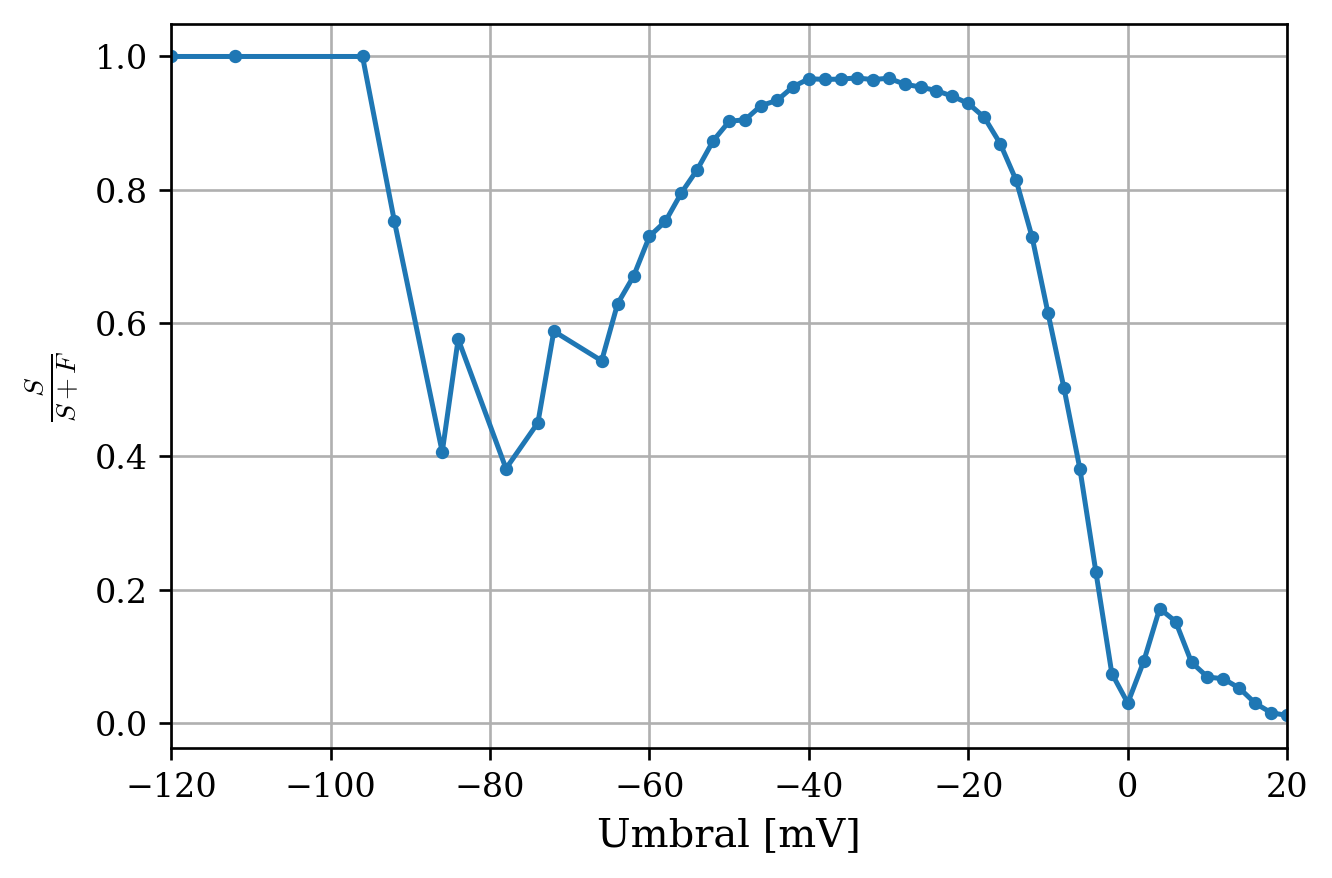

In [88]:
umbrales = vals_unicos[1:]
frac = np.zeros_like(umbrales)
for i, umbral in enumerate(umbrales):  # V
    positivos_d = sum(height_dict["d"][tension_dict["d"] <  umbral])
    positivos_c = sum(height_dict["c"][tension_dict["c"] <  umbral])
    frac[i] = (positivos_d-positivos_c)/(positivos_d)

plt.plot(umbrales*1e3, frac, '.-')
plt.xlabel("Umbral [mV]")
plt.ylabel(r"$\frac{S}{S+F}$")
plt.show()